## Stock price predictions using analysis of news articles


The Efficient Market Hypothesis is a theory whereby share prices reflect all information available to the public. Today, investment companies try to be the fastest at gathering and processing said information. Of course, they use and Machine Learning and Natural Language Processing to extract the most information they can at the fastest possible speed. They use  technical indicators as well as sentiment of available news from every data source available (News, Twitter, Reddit, and probably others) in order to be among the first responders to expected market fluctuations.
I want to demonstrate a basic model of how we can implement Deep Learning methods and Natural Language Processing to combine both news and technical indicators to predict stock price fluctuations.

The textual data is made of 25 daily headlines scraped from the WorldNews subreddit, and the financial data's source is the yahoo finance website. For more info, see project summary. 


This is a more complete  (and visual) tutorial regarding my project.

In [12]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing: News headlines

Let's import the news and take a look at them:
The labels are dropped immediately because they are there for binary classification.


In [13]:
news_data=pd.read_csv('C:\\Users\\Vsh\\Documents\\data\\Stock_predictions\\Combined_News_DJIA.csv')

nrows=news_data['Date'].count()
news_data.index = range(nrows)
news_data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [14]:
news_data.tail()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
1984,2016-06-27,0,Barclays and RBS shares suspended from trading...,Pope says Church should ask forgiveness from g...,Poland 'shocked' by xenophobic abuse of Poles ...,"There will be no second referendum, cabinet ag...","Scotland welcome to join EU, Merkel ally says",Sterling dips below Friday's 31-year low amid ...,No negative news about South African President...,Surge in Hate Crimes in the U.K. Following U.K...,...,German lawyers to probe Erdogan over alleged w...,"Boris Johnson says the UK will continue to ""in...",Richard Branson is calling on the UK governmen...,Turkey 'sorry for downing Russian jet',Edward Snowden lawyer vows new push for pardon...,Brexit opinion poll reveals majority don't wan...,"Conservative MP Leave Campaigner: ""The leave c...","Economists predict UK recession, further weake...","New EU 'superstate plan by France, Germany: Cr...",Pakistani clerics declare transgender marriage...
1985,2016-06-28,1,"2,500 Scientists To Australia: If You Want To ...","The personal details of 112,000 French police ...",S&amp;P cuts United Kingdom sovereign credit r...,Huge helium deposit found in Africa,CEO of the South African state broadcaster qui...,"Brexit cost investors $2 trillion, the worst o...",Hong Kong democracy activists call for return ...,Brexit: Iceland president says UK can join 'tr...,...,"US, Canada and Mexico pledge 50% of power from...",There is increasing evidence that Australia is...,"Richard Branson, the founder of Virgin Group, ...","37,000-yr-old skull from Borneo reveals surpri...",Palestinians stone Western Wall worshipers; po...,Jean-Claude Juncker asks Farage: Why are you h...,"""Romanians for Remainians"" offering a new home...",Brexit: Gibraltar in talks with Scotland to st...,8 Suicide Bombers Strike Lebanon,Mexico's security forces routinely use 'sexual...
1986,2016-06-29,1,Explosion At Airport In Istanbul,Yemeni former president: Terrorism is the offs...,UK must accept freedom of movement to access E...,Devastated: scientists too late to captive bre...,British Labor Party leader Jeremy Corbyn loses...,A Muslim Shop in the UK Was Just Firebombed Wh...,Mexican Authorities Sexually Torture Women in ...,UK shares and pound continue to recover,...,"Escape Tunnel, Dug by Hand, Is Found at Holoca...",The land under Beijing is sinking by as much a...,Car bomb and Anti-Islamic attack on Mosque in ...,Emaciated lions in Taiz Zoo are trapped in blo...,Rupert Murdoch describes Brexit as 'wonderful'...,More than 40 killed in Yemen suicide attacks,Google Found Disastrous Symantec and Norton Vu...,Extremist violence on the rise in Germany: Dom...,BBC News: Labour MPs pass Corbyn no-confidence...,Tiny New Zealand town with 'too many jobs' lau...
1987,2016-06-30,1,Jamaica proposes marijuana dispensers for tour...,Stephen Hawking says pollution and 'stupidity'...,Boris Johnson says he will not run for Tory pa...,Six gay men in Ivory Coast were abused and for...,Switzerland denies citizenship to Muslim immig...,Palestinian terrorist stabs israeli teen girl ...,Puerto Rico will default on $1 billion of debt...,Republic of Ireland fans to be awarded medal f...,...,Googles free wifi at Indian railway stations i...,Mounting evidence suggests 'hobbits' were wipe...,The men who carried out Tuesday's terror attac...,Calls to suspend Saudi Arabia from UN Human Ri...,More Than 100 Nobel Laureates Call Out Greenpe...,British pedophile sentenced to 85 years in US ...,"US permitted 1,200 offshore fracks in Gulf of ...",We will be swimming in ridicule - French beach...,UEFA says no minutes of silence for Istanbul v...,Law Enforcement Sources: Gun Used in Paris Ter...
1988,2016-07-01,1,A 117-year-old woman in Mexico City finally re...,IMF chief backs Athens as permanent Olympic host,"The president of France says if Brexit won, so...",British Man Who Must Give Police 24 Hours' Not...,100+ Nobel laureates 

Number of diffrent dates for news:

In [15]:
print(nrows)

1989


We have 25 news article for every day

In [16]:
columns=news_data.columns
print(columns)

new_columns = ['Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25']

tokenized_news_df=news_data[new_columns]

for i in new_columns:
    tokenized_news_df[i]=tokenized_news_df[i].str.strip('b')
    tokenized_news_df[i]=tokenized_news_df[i].str.strip('"')
    tokenized_news_df[i]=tokenized_news_df[i].str.strip("'")

tokenized_news_df.head()

Index(['Date', 'Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25'],
      dtype='object')


,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,Georgia 'downs two Russian warplanes' as count...,BREAKING: Musharraf to be impeached.,Russia Today: Columns of troops roll into Sout...,Russian tanks are moving towards the capital o...,"Afghan children raped with 'impunity,' U.N. of...",150 Russian tanks have entered South Ossetia w...,"Breaking: Georgia invades South Ossetia, Russi...",The 'enemy combatent' trials are nothing but a...,Georgian troops retreat from S. Osettain capit...,Did the U.S. Prep Georgia for War with Russia?,...,Georgia Invades South Ossetia - if Russia gets...,Al-Qaeda Faces Islamist Backlash,"Condoleezza Rice: ""The US would not act to pre...",This is a busy day: The European Union has ap...,"Georgia will withdraw 1,000 soldiers from Iraq...",Why the Pentagon Thinks Attacking Iran is a Ba...,Caucasus in crisis: Georgia invades South Ossetia,Indian shoe manufactory - And again in a seri...,Visitors Suffering from Mental Illnesses Banne...,No Help for Mexico's Kidnapping Surge
1,Why wont America and Nato help us? If they won...,Bush puts foot down on Georgian conflict,Jewish Georgian minister: Thanks to Israeli tr...,Georgian army flees in disarray as Russians ad...,Olympic opening ceremony fireworks 'faked,What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,An American citizen living in S.Ossetia blames...,Welcome To World War IV! Now In High Definition!,"Georgia's move, a mistake of monumental propor...",...,Israel and the US behind the Georgian aggression?,"""Do not believe TV, neither Russian nor Georgi...",Riots are still going on in Montreal (Canada) ...,China to overtake US as largest manufacturer,War in South Ossetia [PICS],Israeli Physicians Group Condemns State Torture,Russia has just beaten the United States over...,Perhaps *the* question about the Georgia - Rus...,Russia is so much better at war,So this is what it's come to: trading sex for ...
2,Remember that adorable 9-year-old who sang at ...,Russia 'ends Georgia operation,"""If we had no sexual harassment we would have ...",Al-Qa'eda is losing support in Iraq because of...,Ceasefire in Georgia: Putin Outmaneuvers the West,Why Microsoft and Intel tried to kill the XO $...,Stratfor: The Russo-Georgian War and the Balan...,I'm Trying to Get a Sense of This Whole Georgi...,The US military was surprised by the timing an...,U.S. Beats War Drum as Iran Dumps the Dollar,...,U.S. troops still in Georgia (did you know the...,Why Russias response to Georgia was right,"Gorbachev accuses U.S. of making a ""serious bl...","Russia, Georgia, and NATO: Cold War Two",Remember that adorable 62-year-old who led you...,War in Georgia: The Israeli connection,All signs point to the US encouraging Georgia ...,Christopher King argues that the US and NATO a...,America: The New Mexico?,BBC NEWS | Asia-Pacific | Extinction 'by man n...
3,U.S. refuses Israel weapons to attack Iran: r...,When the president ordered to attack Tskhinval...,Israel clears troops who killed Reuters camer...,"Britain\'s policy of being tough on drugs is ""...",Body of 14 year old found in trunk; Latest (ra...,China has moved 10 *million* quake survivors i...,Bush announces Operation Get All Up In Russia'...,Russian forces sink Georgian ships,The commander of a Navy air reconnaissance squ...,92% of CNN readers: Russia's actions in Georgi...,...,Elephants extinct by 2020?,US humanitarian missions soon in Georgia - if ...,Georgia's DDOS came from US sources,"Russian convoy heads into Georgia, violating t...",Israeli defence minister: US against strike on...,Gorbachev: We Had No Choice,Witness: Russian forces head towards Tbilisi i...,Quarter of Russians blame U.S. for conflict: ...,Georgian president says US military will take...,2006: Nobel laureate Aleksander Solzhenitsyn a...
4,All the experts admit that we should legalise ...,War in South Osetia - 89 pictures made by a Ru...,

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def remove_stopwords(text):
    stopwords_list=stopwords.words('english')
    not_stopwords=['not','no'] #We could whitetelist other words too
    words=text.split()
    essential_words = [word for word in words if (word not in stopwords_list or word in not_stopwords) and len(word) > 1]
    return " ".join(essential_words)


In [18]:
#We run the next line to remove stopwords:
for i in new_columns:
    tokenized_news_df[i] = tokenized_news_df[i].astype(str).apply(remove_stopwords)

In [19]:
tokenized_news_df.head()

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,Georgia 'downs two Russian warplanes' countrie...,BREAKING: Musharraf impeached.,Russia Today: Columns troops roll South Osseti...,Russian tanks moving towards capital South Oss...,"Afghan children raped 'impunity,' U.N. officia...",150 Russian tanks entered South Ossetia whilst...,"Breaking: Georgia invades South Ossetia, Russi...",The 'enemy combatent' trials nothing sham: Sal...,"Georgian troops retreat S. Osettain capital, p...",Did U.S. Prep Georgia War Russia?,...,Georgia Invades South Ossetia Russia gets invo...,Al-Qaeda Faces Islamist Backlash,"Condoleezza Rice: ""The US would not act preven...",This busy day: The European Union approved new...,"Georgia withdraw 1,000 soldiers Iraq help figh...",Why Pentagon Thinks Attacking Iran Bad Idea US...,Caucasus crisis: Georgia invades South Ossetia,"Indian shoe manufactory And series ""you not li...",Visitors Suffering Mental Illnesses Banned Oly...,No Help Mexico's Kidnapping Surge
1,Why wont America Nato help us? If wont help us...,Bush puts foot Georgian conflict,Jewish Georgian minister: Thanks Israeli train...,Georgian army flees disarray Russians advance ...,Olympic opening ceremony fireworks 'faked,What Mossad fraudulent New Zealand Passports I...,Russia angered Israeli military sale Georgia,An American citizen living S.Ossetia blames U....,Welcome To World War IV! Now In High Definition!,"Georgia's move, mistake monumental proportions",...,Israel US behind Georgian aggression?,"""Do not believe TV, neither Russian Georgian. ...",Riots still going Montreal (Canada) police mur...,China overtake US largest manufacturer,War South Ossetia [PICS],Israeli Physicians Group Condemns State Torture,Russia beaten United States head Peak Oil,Perhaps *the* question Georgia Russia conflict,Russia much better war,So come to: trading sex food.
2,Remember adorable 9-year-old sang opening cere...,Russia 'ends Georgia operation,"""If no sexual harassment would no children...""",Al-Qa'eda losing support Iraq brutal crackdown...,Ceasefire Georgia: Putin Outmaneuvers West,Why Microsoft Intel tried kill XO $100 laptop,Stratfor: The Russo-Georgian War Balance Power,I'm Trying Get Sense This Whole Georgia-Russia...,The US military surprised timing swiftness Rus...,U.S. Beats War Drum Iran Dumps Dollar,...,U.S. troops still Georgia (did know Georgia fi...,Why Russias response Georgia right,"Gorbachev accuses U.S. making ""serious blunder...","Russia, Georgia, NATO: Cold War Two",Remember adorable 62-year-old led country war ...,War Georgia: The Israeli connection,All signs point US encouraging Georgia invade ...,Christopher King argues US NATO behind Georgia...,America: The New Mexico?,BBC NEWS Asia-Pacific Extinction 'by man not c...
3,U.S. refuses Israel weapons attack Iran: report,When president ordered attack Tskhinvali [the ...,Israel clears troops killed Reuters cameraman,"Britain\'s policy tough drugs ""pointless"", say...",Body 14 year old found trunk; Latest (ransom p...,China moved 10 *million* quake survivors prefa...,Bush announces Operation Get All Up In Russia'...,Russian forces sink Georgian ships,The commander Navy air reconnaissance squadron...,92% CNN readers: Russia's actions Georgia just...,...,Elephants extinct 2020?,US humanitarian missions soon Georgia Russia h...,Georgia's DDOS came US sources,"Russian convoy heads Georgia, violating truce",Israeli defence minister: US strike Iran,Gorbachev: We Had No Choice,Witness: Russian forces head towards Tbilisi b...,Quarter Russians blame U.S. conflict: poll,Georgian president says US military take contr...,2006: Nobel laureate Aleksander Solzhenitsyn a...
4,All experts admit legalise drugs,War South Osetia 89 pictures made Russian sold...,Swedish wrestler Ara Abrahamian throws away me...,Russia exaggerated death toll South Ossetia. N...,Missile That Killed Inside Pakistan May Have B...,Rushdie Condemns Random Hous

In [20]:
NB_WORDS = 40000  # Parameter indicating the number of words we'll put in the dictionary
MAX_LEN = 27  # Maximum number of words in a sequence (95% of words are less than 27 words (done in another analysis))
GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings
NUM_DAYS=1989

In [21]:
tokenized_news_seq=[]
tokenizer = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
for j, i in enumerate (new_columns):
    tokenizer.fit_on_texts(tokenized_news_df[i])
    tokenized_news_seq.append(tokenizer.texts_to_sequences(tokenized_news_df[i]))

In [22]:
def pad_nested_sequences(sequences, dtype='int32'):
    """Pads nested sequences to the same length.
    This function transforms a list of list sequences
    into a 3D Numpy array of shape `(num_samples, max_sent_len, max_word_len)`.
    Args:
        sequences: List of lists of lists.
        dtype: Type of the output sequences.
    # Returns
        x: Numpy array.
    """
    max_sent_len = 25
    max_word_len = MAX_LEN
    for sent in sequences:
        max_sent_len = max(len(sent), max_sent_len)
        for word in sent:
            max_word_len = max_word_len

    x = np.zeros((len(sequences), max_sent_len, max_word_len)).astype(dtype)
    for i, sent in enumerate(sequences):
        for j, word in enumerate(sent):
            if j<max_word_len:
                x[i, j, :len(word)] = word

    return x

In [23]:
tokenized_news_seq_padded=pad_nested_sequences(tokenized_news_seq)
tokenized_news_seq_padded=np.transpose(tokenized_news_seq_padded, (1,0,2))
tokenized_news_seq_padded.shape

(1989, 25, 27)

In [24]:
tokenized_news_seq_padded[0][:5]

array([[  915,  3691,    53,    48,  3692,   361,   579,  2432,    20,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [  627,  8696,  8697,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [   39,   181, 12114,   421, 12115,    64,  2239,   733,   582,
          768,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [   40,  1759,  1456,  1327,   474,    60,  2303,   934,  1826,
          805,  2096,  2404,   181,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [  329,    46,   354, 16912,   339,    14,   249,   165,     4,
         2031,    87,    11,    22,   354,   873,     0,     0,     0,
  

In [25]:
unique, counts = np.unique(tokenized_news_seq_padded, return_counts=True)
len(unique)

3095

In [26]:
from sklearn.model_selection import train_test_split

texts_train , texts_test, _, _ = train_test_split(tokenized_news_seq_padded,tokenized_news_seq_padded  ,test_size=0.1,shuffle=False)

In [28]:
texts_test.shape

(199, 25, 27)

In [29]:
texts_train.shape

(1790, 25, 27)

In [31]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding='utf-8') #Thanks to pytorch assignment
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [32]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((NB_WORDS, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [33]:
dj=pd.read_csv('C:\\Users\\Vsh\\Documents\\data\\Stock_predictions\\DowJones.csv')

In [34]:
nrows_dj=dj['Date'].count()
dj.index = range(nrows_dj)
dj.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-08-07,11655.419922,11655.580078,11416.700195,11431.429688,11431.429688,229610000
1,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320313,11734.320313,212830000
2,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,11782.349609,183190000
3,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,11642.469727,173590000
4,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,11532.959961,182550000


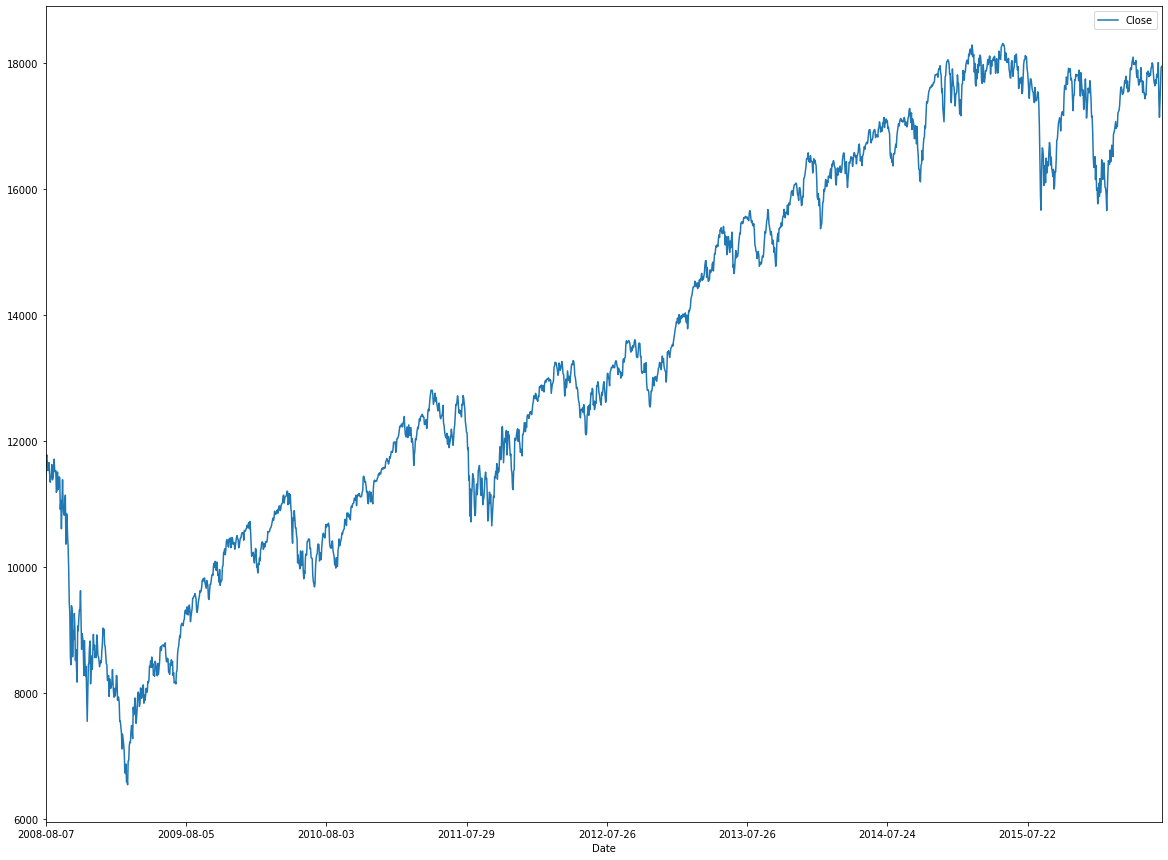

In [36]:
dj.plot(x='Date',y='Close',figsize=(20,15));

In [37]:
dj_long=pd.read_csv('C:\\Users\\Vsh\\Documents\\data\\Stock_predictions\\^DJI.csv')
nrows_dj_long=dj_long['Date'].count()
dj_long.index = range(nrows_dj_long)
dj_long.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-05-01,12818.339844,13029.049805,12793.099609,13010.000000,13010.000000,245480000
1,2008-05-02,13012.530273,13132.459961,12981.830078,13058.200195,13058.200195,205410000
2,2008-05-05,13056.570313,13058.450195,12939.740234,12969.540039,12969.540039,197810000
3,2008-05-06,12968.889648,13046.150391,12863.200195,13020.830078,13020.830078,199370000
4,2008-05-07,13010.820313,13036.709961,12796.190430,12814.349609,12814.349609,235000000


In [38]:
dj_long.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2053,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,17140.240234,138740000
2054,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,17409.720703,112190000
2055,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,17694.679688,106380000
2056,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,17929.990234,133030000
2057,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,17949.369141,82160000


In [39]:
dj_long.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64